In [1]:
import pandas as pd
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Fonctions

## Fonction d'évaluation du score de la prédiction

In [28]:
def rmsle(prediction, actual):
    assert len(prediction) == len(actual)
    return np.sqrt(np.mean(np.power(np.log1p(prediction)-np.log1p(actual),2)))

### Faire de cette fonction un scorer utilisable dans sklearn

In [29]:
from sklearn.metrics import make_scorer
rmsle_scorer = make_scorer(rmsle)

## Fonction d'évaluation de modèle

Cette fonction 
* evalue l'algorithme passé en paramêtre sur les X,y passés
* fit l'algorithme
* crée un graphique avec les influences de chaque feature de X

In [39]:
def evaluate_model(evaluator, X,y):
    from sklearn.cross_validation import cross_val_score
    print 'Evaluator is: ' + str(evaluator)
    print 'Mean score on 20 iterations is: '+str(mean(cross_val_score(evaluator, X, y, rmsle_scorer, cv = 20)))
    lr.fit(X,y)
    pd.DataFrame(lr.coef_, index=X.columns).plot(kind="bar")

## Génération du fichier de Soumission
Cette fonction génére le fichier au format attendu en enlevant les valeurs négatives.

Les paramêtres attendus sont
1. un dataframe comportant une colonne 'id' avec les identifiants des observations
2. un dataframe comportant les prédictions correspondant aux observations (donc classés dans le même ordre) dans une colonne 'cost'

In [30]:
def submitForCaterpillar(X,y):
    from datetime import datetime
    
    # verify if assumptions on input are met
    assert len(X) == len(y)
    assert ('cost' in y.columns)
    assert ('id' in X.columns)
    
    # compute target filename
    timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
    name = 'submit/submit_%s.csv' %timestamp
    
    # initialize target df
    preds = pd.DataFrame()
    # add cost column from y
    preds = pd.DataFrame(y,columns=['cost'])
    # add id column from X
    preds['id'] = X.id
    # reorder df
    preds = preds[['id','cost']]
    
    # Print if negative values were clipped
    negCosts = len (y.copy()[y.cost < 0])
    if negCosts != 0:
        print ('setting '+ str(negCosts)+' negative cost values to zero')
    
    # Clip negative values
    preds.cost = preds.cost.clip(0)
    
    # Generate CSV file 
    preds.to_csv(name,index=False)
    print 'generated '+name

# Caterpillar
## Read train data set

In [3]:
train = pd.read_csv('data/train_set.csv')

In [4]:
# train.shape

In [5]:
# train.dtypes

In [6]:
# train.head()

In [7]:
# train.describe()

##Modèle 0 : quick & Dirty avec un seul fichier sans jointures

### Fonction de découpage du fichier train avec sélection des seules features numériques  

In [8]:
def parse_0(X):
    target = X['cost']
    X = X[['annual_usage', 'min_order_quantity','quantity']]
    return X, target

### Entrainement de l'agorithme de régression linéaire

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

score is 1.21961424554


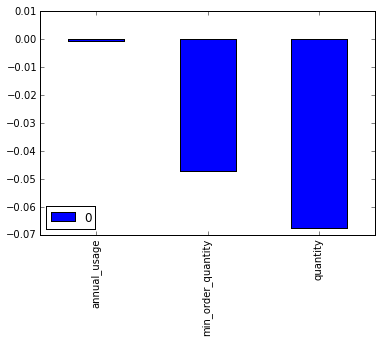

In [12]:
X,y = parse_0(train[train.annual_usage<100000]) # enlève 2 valeurs atypiques. Shape du résultat = (30211, 3)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
lr = LinearRegression()
lr.fit(X_train,y_train)
print('score is '+str(rmsle(lr.predict(X_test),y_test)))
pd.DataFrame(lr.coef_, index=X.columns).plot(kind="bar")

Evaluator is: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean score on 20 iterations is: 1.02679598847


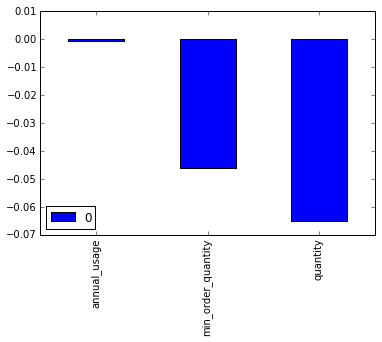

In [40]:
X,y = parse_0(train[train.annual_usage<100000]) # enlève 2 valeurs atypiques. Shape du résultat = (30211, 3)
lr = LinearRegression()
evaluate_model(lr,X,y)

### Générer le submission_set

In [14]:
test = pd.read_csv('data/test_set.csv')
X = test[['annual_usage', 'min_order_quantity','quantity']]
preds = pd.DataFrame(lr.predict(X),columns=['cost'])
submitForCaterpillar(test,preds)

setting 2313 negative cost values to zero
generated submit/submit_2015-08-10-22-57.csv


In [15]:
#test.shape

In [16]:
#test.head()

In [17]:
#preds.head()

In [18]:
#test.count()

In [132]:
#print(X.shape,test.shape,preds.shape)

## Modèle 1. Avec dummysation de bracket pricing

In [44]:
def parse_1(X):
    target = pd.DataFrame([])
    if 'cost' in X.columns:
        # si on passe le jeu de test réel, cost n'est pas là
        target = X['cost']
    X = X[['annual_usage', 'min_order_quantity','quantity','bracket_pricing']]
    to_dum = ['bracket_pricing']
    for col in to_dum:
        dums = pd.get_dummies(X[col], prefix=col)
        X = X.join(dums)
    del X['bracket_pricing']
    return X, target

In [45]:
X,y = parse_1(train.copy())

In [25]:
X.head()

,annual_usage,min_order_quantity,quantity,bracket_pricing_No,bracket_pricing_Yes
0,0,0,1,0,1
1,0,0,2,0,1
2,0,0,5,0,1
3,0,0,10,0,1
4,0,0,25,0,1


### Application d'une régression linéaire simple

Evaluator is: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean score on 20 iterations is: 0.953880900538


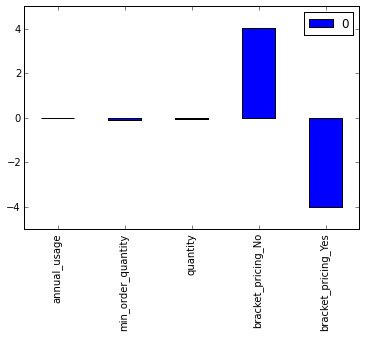

In [58]:
X,y = parse_1(train.copy())
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
evaluate_model(lr,X,y)

### Génération fichier de soumission

In [62]:
test = pd.read_csv('data/test_set.csv')
X, y = parse_1(test)
lr.predict(X)
preds = pd.DataFrame(lr.predict(X),columns=['cost'])
submitForCaterpillar(test,preds)

setting 109 negative cost values to zero
generated submit/submit_2015-08-10-23-32.csv


## Autre essai à refactorer

In [63]:
train_base = pd.read_csv('data/train_set.csv')
train_br =  train_base[train_base.bracket_pricing=="Yes"]
train_br = train_br[train_br.annual_usage<100000]
train_br.bracket_pricing.value_counts()

Yes    26282
dtype: int64

In [64]:
train_nbr = train_base[train_base.bracket_pricing=="No"]
train_nbr = train_nbr[train_nbr.annual_usage<100000]
train_nbr.bracket_pricing.value_counts()

No    3929
dtype: int64

In [65]:
X,y = parse_1(train_br)

In [66]:
X = X[['annual_usage', 'quantity']]

Evaluator is: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean score on 20 iterations is: 0.910097688146


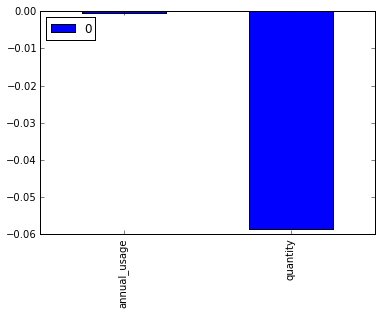

In [67]:
evaluate_model(lr,X,y)

In [68]:
pd.merge(train,tube, on='tube_assembly_id')

NameError: name 'tube' is not defined

## Appliquer un random Forrest

In [224]:
rmsle(train.cost, np.ones(train.shape[0])*train.cost.mean())

0.94748992900412188

Evaluator is: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Mean score on 20 iterations is: 0.578529298492


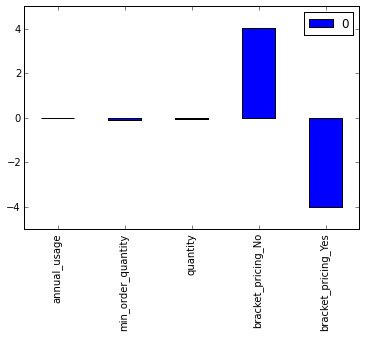

In [69]:
import sklearn.ensemble as en
rf = en.RandomForestRegressor(n_estimators=40, max_depth=25)
X,y = parse_1(train.copy())
evaluate_model(rf,X,y)

## ajouter des variables par join

In [321]:
pd.read_csv('data/train_set.csv').head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [327]:
def parse_2(X):
    target = pd.DataFrame([])
    if 'cost' in X.columns:
        # si on passe le jeu de test réel, cost n'est pas là
        target = X['cost']
        X = X[['annual_usage', 'min_order_quantity','quantity','bracket_pricing','wall','length', 'num_bends','bend_radius','num_boss','num_bracket','other']]
    else:
        X = X[['id','annual_usage', 'min_order_quantity','quantity','bracket_pricing','wall','length', 'num_bends','bend_radius','num_boss','num_bracket','other']]
  
    to_dum = ['bracket_pricing']
    for col in to_dum:
        dums = pd.get_dummies(X[col], prefix=col)
        X = X.join(dums)
    del X['bracket_pricing']
    return X, target

In [233]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [231]:
tube = pd.read_csv('data/tube.csv')
tube.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [232]:
comp_adaptator = pd.read_csv('data/comp_adaptor.csv')
comp_adaptator.head()

,component_id,component_type_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,connection_type_id_2,length_2,thread_size_2,thread_pitch_2,nominal_size_2,hex_size,unique_feature,orientation,weight
0,C-0005,CP-028,NaN,58.4,A-001,B-001,NaN,1.312,12,NaN,A-001,B-004,NaN,1.000,11.5,NaN,34.93,No,No,0.206
1,C-0006,CP-028,NaN,34.8,A-001,B-001,NaN,0.437,20,NaN,A-001,B-005,NaN,0.750,16.0,NaN,22.20,No,No,0.083
2,C-1435,CP-028,NaN,20.3,A-007,B-004,NaN,NaN,NaN,15.88,A-001,B-007,NaN,0.875,18.0,NaN,22.22,No,No,0.023
3,C-1546,CP-028,NaN,26.4,A-007,B-004,NaN,0.125,27,NaN,A-001,B-004,NaN,0.125,27.0,NaN,15.88,No,No,0.026
4,C-1583,CP-028,NaN,44.5,A-001,B-005,NaN,1.312,12,NaN,A-007,B-005,NaN,1.062,12.0,NaN,38.10,No,No,0.256


In [258]:
train = pd.merge(train,tube, on='tube_assembly_id')

In [256]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id_x,diameter_x,...,bend_radius_y,end_a_1x_y,end_a_2x_y,end_x_1x_y,end_x_2x_y,end_a_y,end_x_y,num_boss_y,num_bracket_y,other_y
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0


##réappliquer le RF

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
0.453270651698


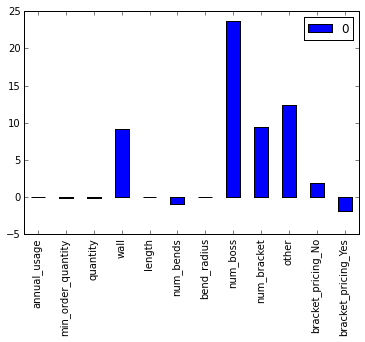

In [341]:
rf = en.RandomForestRegressor(n_estimators=40, max_depth=25)
X,y = parse_2(train.copy())
evaluate_model(rf,X,y)

### comparer avec une régression linéaire de base

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.850484957799


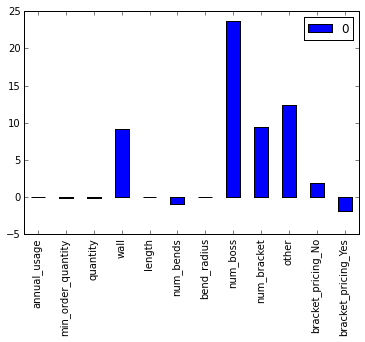

In [328]:
X,y = parse_2(train.copy())
lr = LinearRegression()
evaluate_model(lr,X,y)

## soumission du RF avec matrice joinée sur tube

In [355]:
def parse_3(X):
    print X.columns

    X = X[['annual_usage', 'min_order_quantity','quantity','bracket_pricing','wall','length', 'num_bends','bend_radius','num_boss','num_bracket','other']]
    
    to_dum = ['bracket_pricing']
    for col in to_dum:
        dums = pd.get_dummies(X[col], prefix=col)
        X = X.join(dums)
    del X['bracket_pricing']
    return X

In [356]:
test_submit = pd.read_csv('data/test_set.csv')
test_submit.head()

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25


In [357]:
test_submit = pd.merge(test_submit,tube, on='tube_assembly_id')
test_submit.head()


,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,material_id,diameter,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0


In [358]:
#test_submit = test_submit.drop(['id'],axis=1)
# Codage de la matrice X
X_submit = parse_3(test_submit.copy())
#X_submit2 = X_submit.drop(['id'],axis=1)
# Initialisation et évaluation de la RF
rf = en.RandomForestRegressor(n_estimators=40, max_depth=25)
#X,y = parse_2(train.copy())
rf.fit(X,y)
#evaluate_model(rf,X_submit,y)
# Prediction du y sur X
y_submit = rf.predict(X_submit)
# génréation du fichier de submit
submit(test_submit,y_submit)

Index([u'id', u'tube_assembly_id', u'supplier', u'quote_date', u'annual_usage',
       u'min_order_quantity', u'bracket_pricing', u'quantity', u'material_id',
       u'diameter', u'wall', u'length', u'num_bends', u'bend_radius',
       u'end_a_1x', u'end_a_2x', u'end_x_1x', u'end_x_2x', u'end_a', u'end_x',
       u'num_boss', u'num_bracket', u'other'],
      dtype='object')
generated submit/submit_2015-07-17-16-26.csv


array([ 26.05002409,  15.56851484,   8.42750421, ...,   3.66086399,
        18.09940332,  36.72943919])

In [316]:
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [317]:
X.head()

,annual_usage,min_order_quantity,quantity,wall,length,num_bends,bend_radius,num_boss,num_bracket,other,bracket_pricing_No,bracket_pricing_Yes
0,0,0,1,0.71,137,8,19.05,0,0,0,0,1
1,0,0,2,0.71,137,8,19.05,0,0,0,0,1
2,0,0,5,0.71,137,8,19.05,0,0,0,0,1
3,0,0,10,0.71,137,8,19.05,0,0,0,0,1
4,0,0,25,0.71,137,8,19.05,0,0,0,0,1
